# Assignment 8 - k-Nearest Neighbors (kNNs)
(20 points)

### Add your name(s) and EIDs below
- Student Name: Dylan Lam
- Student UT EID: DXL85
- Partner Name: Alexander Romero-Barrionuevo
- Partner UT EID: ANR3784


# k-Nearest Neighbors
For this assignment, we are going explore one new classification technique: k nearest neighbors.

We are using a different version of the Melbourne housing data set from earlier in the semester, split into training and testing sets for you. Our goal is to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, you will understand how to build and use a kNN model, and improve your data cleaning and data preparation skills. 

In [917]:
# These are the libraries you will use for this assignment.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

In [918]:
# Start off by loading the training dataset.
df_melb = pd.read_csv('/Users/dylanlam/Documents/GitHub/data_science_practice_and_skills/datasets/melb_data_train.csv')

## Q1 

**Fix our "Date" column to be numeric**: If we inspect our dataframe `df_melb` using the `dtypes` property, we see that the column `Date` is an `object`.  However, we think this column might contain useful information, so your goal is to convert it to [Unix time](https://en.wikipedia.org/wiki/Unix_time).

Unix time is the number of secconds since a fixed time known as the "Unix epoch", which is midnight on January 1st, 1970. For example, the Unix time for March 10th, 2023 is 1,678,474,369 seconds.

- **Use only the libraries imported above** imported libraries to create a new column `UnixTime`. 
    - Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  
- Print out the min and max epoch time to check your work.  
- Drop the original `Date` column. 

The Python [reference for time](https://docs.python.org/3/library/time.html) can help you with your conversion to Unix time.

(**3 points**)

In [919]:
# For reference, here are the data types of each column.
df_melb.dtypes

Rooms             int64
Type             object
Price             int64
Date             object
Distance        float64
Postcode          int64
Bathroom          int64
Car             float64
Landsize          int64
BuildingArea    float64
YearBuilt       float64
dtype: object

<!-- BEGIN QUESTION -->



In [920]:
df_melb['Date']

0      26/07/2016
1          4/3/17
2          7/5/16
3      17/06/2017
4      16/09/2017
          ...    
970    15/10/2016
971    17/06/2017
972        4/3/17
973      12/11/16
974       10/9/16
Name: Date, Length: 975, dtype: object

In [921]:
def standardize_date(date_string):
  """Standardize a date string to a standard format.

  Rules:
  - You can assume the input string is of the form day/month/year.
  - Fixed date strings should be of the form DD/MM/YYYY. If a day is
    one digit, append zeros.
  - If the input string's year is two digits (e.g. 02), assume
    the year is in the 2000s (e.g. 2002).
  """
  split_date = date_string.split('/')
  day = split_date[0]
  month = split_date[1]
  year = split_date[2]
  if len(day) == 1:
    day = '0' + day
  if len(month) == 1:
    month = '0' + month
  if len(year) == 2:
    year = '20' + year
  
  fixed_date_string = day + '/' + month + '/' + year
  return fixed_date_string

def seconds_since_epoch(date):
  # Convert the date string directly to a timestamp using strptime() and mktime() functions:
  # strptime() parses the input date string according to the given format and returns a time tuple
  # mktime() then converts the time tuple into the number of seconds since the epoch (January 1, 1970)
  seconds = time.mktime(time.strptime(date, '%d/%m/%Y'))

  return int(seconds)

def replace_date_with_unix(df):
  """Given a Melbourne dataset dataframe, replace the Date column
  with a UnixTime column.

  Hint: Call standardize_date within this function.
  """
  # Standardize the date column.
  standardized_dates = []
  unix_list = []
  for date in df['Date']:
    standardized_dates.append(standardize_date(date))
  for i in standardized_dates:
    unix_list.append(seconds_since_epoch(i))

  # Create the UnixTime column
  df['UnixTime'] = unix_list
  
  # Drop the date column.
  df = df.drop('Date', axis = 1)
  return df

In [922]:
df_melb_q1 = replace_date_with_unix(df_melb)

# Print the cleaned UnixTime values.
print('Min UnixTime:', df_melb_q1['UnixTime'].min())
print('Max UnixTime:', df_melb_q1['UnixTime'].max())

Min UnixTime: 1454565600
Max UnixTime: 1506142800


<!-- END QUESTION -->

## Q2 

**Use imputation to fill in missing values**: kNN doesn't work when some attributes are not present, so we must fill in all the missing values in `df_melb` with something. As a simple estimate, we will fill in missing values with the **mean** of that value/column.

What we're trying to classify ('h'ome/'d'u'plex/'t'ownhouse), also knonw as the **target**, is store in the `Type` column. We define a variable `target_col` which lets you automatically infer which column is the target. During imputation, we should skip this target column.

- Use `df_melb_q1`, i.e. the result from Q1.
- Save the mean of each column in a dictionary `dict_imputation`. Keys are an attribute's column name, and values are that attribute's mean.
- Use `dict_imputation` to imputate the missing values in `df_melb_q1`.
- Store the imputated dataframe in `df_melb_q2`.

(**3 points**)

<!-- BEGIN QUESTION -->



In [923]:
def build_imputation_dict(df,target_col):
    """Collect the mean values of each column, excluding NaN values
    and the target column.
    """
    dict_imputation = {}

    # Get the mean value of each column excluding NaN values
    for column in df.drop(target_col, axis=1):
        dict_imputation[column] = df[column].dropna().mean()
    return dict_imputation

def impute(df, dict_imputation, target_col):
    """Imputate a dataframe, replacing missing values with those
    given in dict_imputation. Do not imputate target_col."""
    for column, mean_value in dict_imputation.items():
        if column != target_col:
            df[column].fillna(mean_value, inplace=True)
    return df

In [924]:
# Define the target column as a string
target_col = 'Type'

# Collect imputation values
dict_imputation = build_imputation_dict(df_melb_q1, target_col)

# Imputate the dataframe
df_melb_q2 = impute(df_melb_q1, dict_imputation, target_col)

In [925]:
# Check your results
dict_imputation

{'Rooms': 2.710769230769231,
 'Price': 941972.2953846154,
 'Distance': 10.206256410256408,
 'Postcode': 3110.873846153846,
 'Bathroom': 1.4543589743589744,
 'Car': 1.4938398357289528,
 'Landsize': 514.2184615384615,
 'BuildingArea': 131.379476861167,
 'YearBuilt': 1971.0204429301534,
 'UnixTime': 1485054996.9230769}

In [926]:
# Check your results
df_melb_q2.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,UnixTime
0,3,t,732000,5.6,3101,1,1.0,904,110.000000,1980.000000,1469509200
1,3,h,1001000,12.6,3020,1,5.0,879,131.379477,1971.020443,1488607200
2,2,u,605000,7.4,3185,1,1.0,722,131.379477,1970.000000,1462597200
3,3,h,757500,18.8,3170,2,1.0,145,131.379477,1971.020443,1497675600
4,4,h,721000,17.9,3082,2,2.0,603,131.379477,1971.020443,1505538000


<!-- END QUESTION -->

## Q3

**Normalize all attributes to be between [0,1]**: Normalize all the attribute columns in `df_melb_q2` so they have a value between zero and one (inclusive). 

To do this, we will build a dictionary `dict_normalize`, with column names for keys and (min, max) tuples for values, which are the min (resp. max) value found in the dataframe for that column. Just like in Q2, we do not normalize the target column.

After creating `dict_normalize`, we will use it to normalize each column and generate a new dataframe, `df_melb_q3`. The resulting dataframe is now your model that you can use to classify new data points.

- Use `df_melb_q2`, i.e. the result from Q2.
- Save the minimum and maximum values of each column in a dictionary `dict_normalize`. Keys are an attribute's column name, and values are a (min, amx) tuple for that column,
- Use `dict_normalize` to normalize the missing values in `df_melb_q2`.
- Store the imputated dataframe in `df_melb_q3`.

(**3 points**)

<!-- BEGIN QUESTION -->



In [927]:
def build_normalization_dict(df, target_col):
    """Collect the (min, max) values of each column, except the
    target column.
    """
    dict_normalize = {}
    # Get the min and max values of each column.
    for column in df.drop(target_col, axis=1):
        dict_normalize[column] = (df[column].dropna().min(), df[column].dropna().max())
    return dict_normalize

def normalize(df, dict_normalize, target_col):
    """Normalize a dataframe, setting all values to the range [0, 1]
    using (min, max) values in dict_normalize. Do not normalize target_col."""
    for column in df.drop(target_col, axis=1):
        min_val, max_val = dict_normalize[column]
        df[column] = (df[column] - min_val) / (max_val - min_val)
    return df

In [928]:
# Define the target column as a string
target_col = 'Type'

# Collect normalization values
dict_normalize = build_normalization_dict(df_melb_q2, target_col)

# Normalize the dataframe
df_melb_q3 = normalize(df_melb_q2, dict_normalize, target_col)

In [929]:
# Check your results
dict_normalize

{'Rooms': (1, 7),
 'Price': (210000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3000, 3810),
 'Bathroom': (0, 5),
 'Car': (0.0, 8.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 3558.0),
 'YearBuilt': (1850.0, 2016.0),
 'UnixTime': (1454565600, 1506142800)}

In [930]:
# Check your results
df_melb_q3.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,UnixTime
0,0.333333,t,0.108524,0.105150,0.124691,0.2,0.125,0.021836,0.030916,0.783133,0.289733
1,0.333333,h,0.164449,0.255365,0.024691,0.2,0.625,0.021232,0.036925,0.729039,0.660013
2,0.166667,u,0.082121,0.143777,0.228395,0.2,0.125,0.017440,0.036925,0.722892,0.155720
3,0.333333,h,0.113825,0.388412,0.209877,0.4,0.125,0.003502,0.036925,0.729039,0.835834
4,0.500000,h,0.106237,0.369099,0.101235,0.4,0.250,0.014565,0.036925,0.729039,0.988274


<!-- END QUESTION -->

## Q4 

**Prepare the test data**: Load in `melb_data_test.csv` and repeat the steps in Q1, Q2, and Q3 (unix time, imputation, and normalization).

(**1 point**)

<!-- BEGIN QUESTION -->



In [931]:
# Load the test dataframe
df_melb_test = pd.read_csv('/Users/dylanlam/Documents/GitHub/data_science_practice_and_skills/datasets/melb_data_test.csv')

# Clean the dates, add unix time
df_melb_test = replace_date_with_unix(df_melb_test)

# Impute the dataframe
target_col = 'Type'
dict_imputation_test = build_imputation_dict(df_melb_test, target_col)
df_melb_test = impute(df_melb_test, dict_imputation_test, target_col)


# Normalize the dataframe
dict_normalize_test = build_normalization_dict(df_melb_test, target_col)
df_melb_test = normalize(df_melb_test, dict_normalize, target_col)



In [932]:
# Check your results
df_melb_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,UnixTime
0,0.166667,t,0.120582,0.225322,0.056790,0.4,0.125,0.005024,0.035694,0.963855,0.835834
1,0.333333,h,0.238046,0.173820,0.088889,0.2,0.250,0.022126,0.041901,0.707136,0.425421
2,0.666667,h,0.540541,0.120172,0.176543,0.4,0.250,0.014903,0.041901,0.707136,0.345013
3,0.333333,h,0.133056,0.210300,0.041975,0.2,0.125,0.014324,0.033165,0.722892,0.355064
4,0.333333,h,0.124740,0.800429,0.245679,0.2,0.250,0.020169,0.033165,0.662651,0.871013


<!-- END QUESTION -->

## Q5

**Write the kNN classifier function**: Your function, `predict_knn` will take in the following four parameters:
- Training dataframe `df_train`
- Hyperparameter `k`
- Testing sample `test_sample` (one row of the DataFrame, we can generate it using `iloc` or `iterrows`).
- Target column string `target_col`, which defines the variable we want to predict.

It will predict which class `test_sample` belongs to, based on the `k` nearest neighbors to the sample.

- We assume `df_train` is normalized/imputated, contains all attributes, and also contains the target column.
- Likewise, we assume `test_sample` is normalized/imputated and contains all attributes. (But, it does not have to have the target column).

*Hint*: To find the distance between the test sample and any element of the training dataset, you may use the [L2 norm function from numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

(**5 points**)

<!-- BEGIN QUESTION -->



In [933]:
def predict_knn(df_train: pd.DataFrame, k: int, 
                test_sample: pd.Series, target_col: str):
    """Use the k-nearest neighbors algorithm to predict the class of a test-sample,
    given a training set.
    
    Parameters:
        df_train:    DataFrame of training samples
        k:           Number of neighbors to consider
        test_sample: Single evaluation sample
        target_col:  Name of the target variable (column)

    Returns:
        prediction: Predicted class of the test sample using kNN.
    """
    # Convert the test sample to numeric data type
    test_sample_numeric = test_sample.drop(target_col).astype(float)
    
    # Calculate the Euclidean distances between the test sample and all training samples
    distances = np.linalg.norm(df_train.drop(columns=[target_col]) - test_sample_numeric, axis=1)
    
    # Sort the distances and get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    
    # Get the corresponding target values of the k nearest neighbors
    nearest_targets = df_train.iloc[nearest_indices][target_col]
    
    # Predict the class based on the majority vote of the k nearest neighbors
    prediction = nearest_targets.mode()[0]
    
    return prediction



In [934]:
df_train = df_melb_q3
k = 5
test_sample = df_melb_test.iloc[0]
target_col = 'Type'
predict_knn(df_train, k, test_sample, target_col)

't'

<!-- END QUESTION -->

## Q6 

**Compute the accuracy using different k values**: For each value of $k$ in the set $\{1,3,13,25,50,100\}$, compute the kNN prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$.

- Use your imputed, normalize training dataframe (`df_melb_q3`).
- Use your imputed, normalized testing dataframe (`df_melb_test`).
- Have an outer loop over the k-values, and an inner loop computing the prediction for each testing sample under that k-value.

Which value of $k$ would you choose? Why?

(This can take a while to run; probably at least 5-10 minutes.)

(**5 points - 3 for implementation, 1 for plot, 1 for description**).

(**This question will be manually graded.**)

<!-- BEGIN QUESTION -->



In [935]:
# Sweep over the k-values. Place your accuracies for each k-value in acc_k.
poss_k = [1, 3, 13, 25, 50, 100]
acc_k = []

# Your code goes below.
for k in poss_k:
    correct_predictions = 0
    
    for index, test_sample in df_melb_test.iterrows():
        prediction = predict_knn(df_melb_q3, k, test_sample, target_col)
        actual = test_sample[target_col]
        
        if prediction == actual:
            correct_predictions += 1
    
    accuracy = correct_predictions / len(df_melb_test)
    acc_k.append(accuracy)

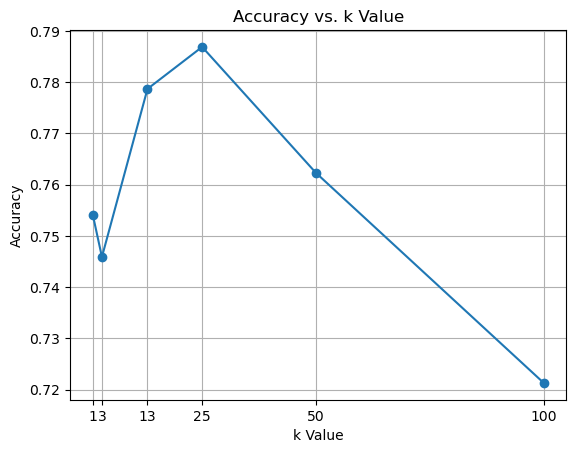

In [936]:
# Plot your accuracies for each k-value.
plt.plot(poss_k, acc_k, marker='o')
plt.title('Accuracy vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.xticks(poss_k)
plt.grid(True)
plt.show()


Among the k values tested (1, 3, 13, 25, 50, and 100), a k value of 25 stands out as the optimal choice. This selection is based on the observed peak in accuracy, indicating that with 25 nearest neighbors considered, the classifier achieves the highest overall accuracy on the test set.

<!-- END QUESTION -->

